In [18]:
# Import necessary modules/libraries
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Import custom utility functions
from utils import p, expected, sampl_fair_opt_step, opt_step

In [29]:
# Set experiment parameters
np.random.seed(1)

# Distribution parameters
mean_a, std_a = 0.5, 1
mean_b, std_b = 0.0, 1

# Domain of alpha values to test
alpha_min, alpha_max = 0.01, 0.6
alphas = np.linspace(alpha_min, alpha_max, num=60)

# Sample size of each distribution
n = 5

# Generate samples from normal distributions
a = np.random.normal(mean_a, std_a, n)
b = np.random.normal(mean_b, std_b, n)
a.sort(), b.sort()
w_a = len(a) / (len(a) + len(b))
w_b = 1 - w_a

#Step Parameters

# U+ / U- > C+ / C-
u_plus = 1
u_minus = -1.1
c_plus = 1
c_minus = -0.405509
# -0.4056
# -0.40551

In [20]:
# Assumptions
print(f' Assumption 1: {p.__doc__} ')
print(f' Assumption 2: \n U+ / U- > C+ / C- is {(u_plus / u_minus) > (c_plus / c_minus)}' )

 Assumption 1: 
    p : a monotonic function, X -> [0,1], e.g. sigmoid
     
 Assumption 2: 
 U+ / U- > C+ / C- is True


In [21]:
# Single step optimization

x_alphas = []
y_mean_A, y_mean_B = [], []
y_thresh_A, y_thresh_B = [], []
y_util = []
y_pof = [] # Price of fairness


y_opt_util = []

B_temp = None

opt_util_A, opt_util_B = opt_step(a, u_plus, u_minus, c_plus, c_minus)[0], opt_step(b, u_plus, u_minus, c_plus, c_minus)[0]
opt_util_A, opt_util_B  = expected(opt_util_A, 1, -1.1), expected(opt_util_B, 1, -1.1)
opt_util_A, opt_util_B = np.sum(opt_util_A), np.sum(opt_util_B)
y_opt = w_a * opt_util_A + w_b * opt_util_B

for alpha in tqdm(alphas):
    results = sampl_fair_opt_step(a, b, u_plus, u_minus, c_plus, c_minus, alpha)
    thresh_A, thresh_B, max_util, (A, B) = results
    if np.abs(A - B) > alpha:
        continue
    else:
        x_alphas.append(alpha)
        y_mean_A.append(A)
        y_mean_B.append(B)
        y_thresh_A.append(thresh_A)
        y_thresh_B.append(thresh_B)
        y_util.append(max_util)
        pof = 1 - (max_util/y_opt)
        y_pof.append(pof)

100%|██████████| 60/60 [00:00<00:00, 5685.65it/s]


In [22]:
def plot_graphs():
    
    # Traces
    thresholds_A = go.Scatter(x=x_alphas, y=y_thresh_A, mode='markers', name="Fair Threshold (A)")
    thresholds_B = go.Scatter(x=x_alphas, y=y_thresh_B, mode='markers', name="Fair Threshold (B)") 
    utilities = go.Scatter(x=x_alphas, y=y_util, mode='markers', name='Utility', yaxis='y2')

    # Create figure
    fig = go.Figure(data=[thresholds_A, thresholds_B, utilities])

    # Add toggle buttons
    fig.update_layout(
        height = 600,
        title='Single Step Thresholding Policy',
        xaxis=dict(title="Alpha"),
        yaxis=dict(title="Threshold"),
        yaxis2=dict(
            title="Utility",
            overlaying="y",
            side="right"
        ),
        legend=dict(
            x=0,          # Right edge of the plotting area
            #y=1,          # Top of the plotting area
            xanchor='right',   # Legend's left edge aligns at x=1
            yanchor='top'     # Legend's top edge aligns at y=1
        ),
        showlegend=True,
    )

    fig.show()
plot_graphs()

In [23]:
# Experiment 0: Check if vectorized algorithm is the same as the original
from experiment_0 import experiment_0
print( (x_alphas, y_thresh_A, y_thresh_B) == experiment_0(a, b, u_plus, u_minus, c_plus, c_minus, w_a, w_b, alphas, a, b) )

100%|██████████| 60/60 [00:00<00:00, 247.84it/s]

True


In [24]:
# Experiment 2
from experiment_2 import experiment_2
test_alpha = 0.52
ex2a, ex2b = experiment_2(a, b, u_plus, u_minus, c_plus, c_minus, test_alpha, w_a, w_b, thresh_B, a, alphas)
ex2a.update_layout(
    xaxis_title ='Threshold A (using samples)'
)
ex2a.show()
#ex2b.show()

trace1 = ex2a.data[1]
trace2 = ex2a.data[2]
mean_diffs = dict(zip(trace1.x, trace1.y))
utilities = dict(zip(trace2.x, trace2.y))

y_thresh_A = np.array(y_thresh_A)
y_thresh_B = np.array(y_thresh_B)
x_alphas = np.array(x_alphas)
indices = np.where(y_thresh_A < y_thresh_B)[0]
test_alphas  = x_alphas[indices]
print(test_alphas)
#test_alphas = np.arange(0.54, 0.63, 0.01)
results = []

for test_alpha in test_alphas:
    # Filter mean_diffs under current threshold
    filtered = {k: v for k, v in mean_diffs.items() if v < test_alpha}

    # Find before and after keys
    before_keys = [k for k in filtered if k < 0]
    after_keys = [k for k in filtered if k > 0]

    before = max(before_keys) if before_keys else None
    after = min(after_keys) if after_keys else None

    if before is not None and after is not None:
        # Prepare data
        utility_before = utilities[before]
        utility_after = utilities[after]
        utility_diff = np.abs(utility_after - utility_before)

        # Build vertical block
        block = pd.DataFrame([
            {
                'Test Alpha': round(test_alpha, 3),
                'Side': 'Negative',
                'Threshold': before,
                'Mean Difference': mean_diffs[before],
                'Utility': utility_before
            },
            {
                'Test Alpha': round(test_alpha, 3),
                'Side': 'Positive',
                'Threshold': after,
                'Mean Difference': mean_diffs[after],
                'Utility': utility_after
            },
            {
                'Test Alpha': round(test_alpha, 3),
                'Side': 'Δ Utility',
                'Threshold': '',
                'Mean Difference': '',
                'Utility': utility_diff
            }
        ])

        print(block.to_string(index=False))
        print("--------")


ImportError: cannot import name 'alt_fair_opt_step' from 'utils' (c:\Users\joelj\OneDrive\Desktop\RoAR\fairness\utils.py)

In [25]:
def double_step(a, b, u_plus, u_minus, c_plus, c_minus, alphas):
    a = np.asarray(a)
    b = np.asarray(b)

    delta_A = expected(a, c_plus, c_minus)
    delta_B = expected(b, c_plus, c_minus)

    # Reshape matrices
    # Creates vector by vector matrices for a, b, delta_A, and delta_B
    N = a.shape[0]
    A_matrix = np.repeat(a, N).reshape((N, N))
    B_matrix = np.repeat(b, N).reshape((N, N))
    delta_A_matrix = np.repeat(delta_A, N).reshape((N, N))
    delta_B_matrix = np.repeat(delta_B, N).reshape((N, N))

    # === First Step ===
    A_matrix = np.where(A_matrix > A_matrix.T, A_matrix + delta_A_matrix, A_matrix)
    B_matrix = np.where(B_matrix > B_matrix.T, B_matrix + delta_B_matrix, B_matrix)

    # === Second Step ===

    # Compute expected change for updated samples
    delta_A = expected(A_matrix, c_plus, c_minus)
    delta_B = expected(B_matrix, c_plus, c_minus)

    # === Step 3: Get thresholds from matrices ===
    a_thresh = A_matrix.flatten()
    b_thresh = B_matrix.flatten()

    # === Step 4: Vectorized thresholding ===

    # Shape: [T_a, 1, N, N] and [1, T_b, N, N]
    A_expanded = A_matrix[np.newaxis, np.newaxis, :, :]
    B_expanded = B_matrix[np.newaxis, np.newaxis, :, :]

    # Thresholds reshaped to [T_a, 1, 1, 1] and [1, T_b, 1, 1]
    a_thresh = a_thresh[:, np.newaxis, np.newaxis, np.newaxis]
    b_thresh = b_thresh[np.newaxis, :, np.newaxis, np.newaxis]

    # Broadcast delta_A and delta_B for use in the update
    delta_A_broadcast = delta_A  # shape: (N, N)
    delta_B_broadcast = delta_B

    # Apply second-step policy over all threshold pairs
    temp_A = np.where(A_expanded > a_thresh, A_expanded + delta_A_broadcast, A_expanded)
    temp_B = np.where(B_expanded > b_thresh, B_expanded + delta_B_broadcast, B_expanded)
    
    utilities = w_a * expected(temp_A, u_plus, u_minus) + w_b * expected(temp_B, u_plus, u_minus)
    mean_diffs = np.mean(np.abs(temp_A - temp_B), axis=(2, 3))

    # Result shapes: [T_a, T_b, N, N]
    return temp_A, temp_B, utilities
temp_A, temp_B, utilities = double_step(a, b, u_plus, u_minus, c_plus, c_minus, alphas)
import matplotlib.pyplot as plt
import seaborn as sns

# Assume utilities is a 2D array of shape (T_a, T_b)
plt.figure(figsize=(10, 8))
sns.heatmap(utilities, cmap='viridis', xticklabels=True, yticklabels=True)
plt.title("Utilities Heatmap")
plt.xlabel("Threshold index (b)")
plt.ylabel("Threshold index (a)")
plt.colorbar(label='Utility')
plt.tight_layout()
plt.show() 


ValueError: Must pass 2-d input. shape=(100, 100, 10, 10)

<Figure size 1000x800 with 0 Axes>

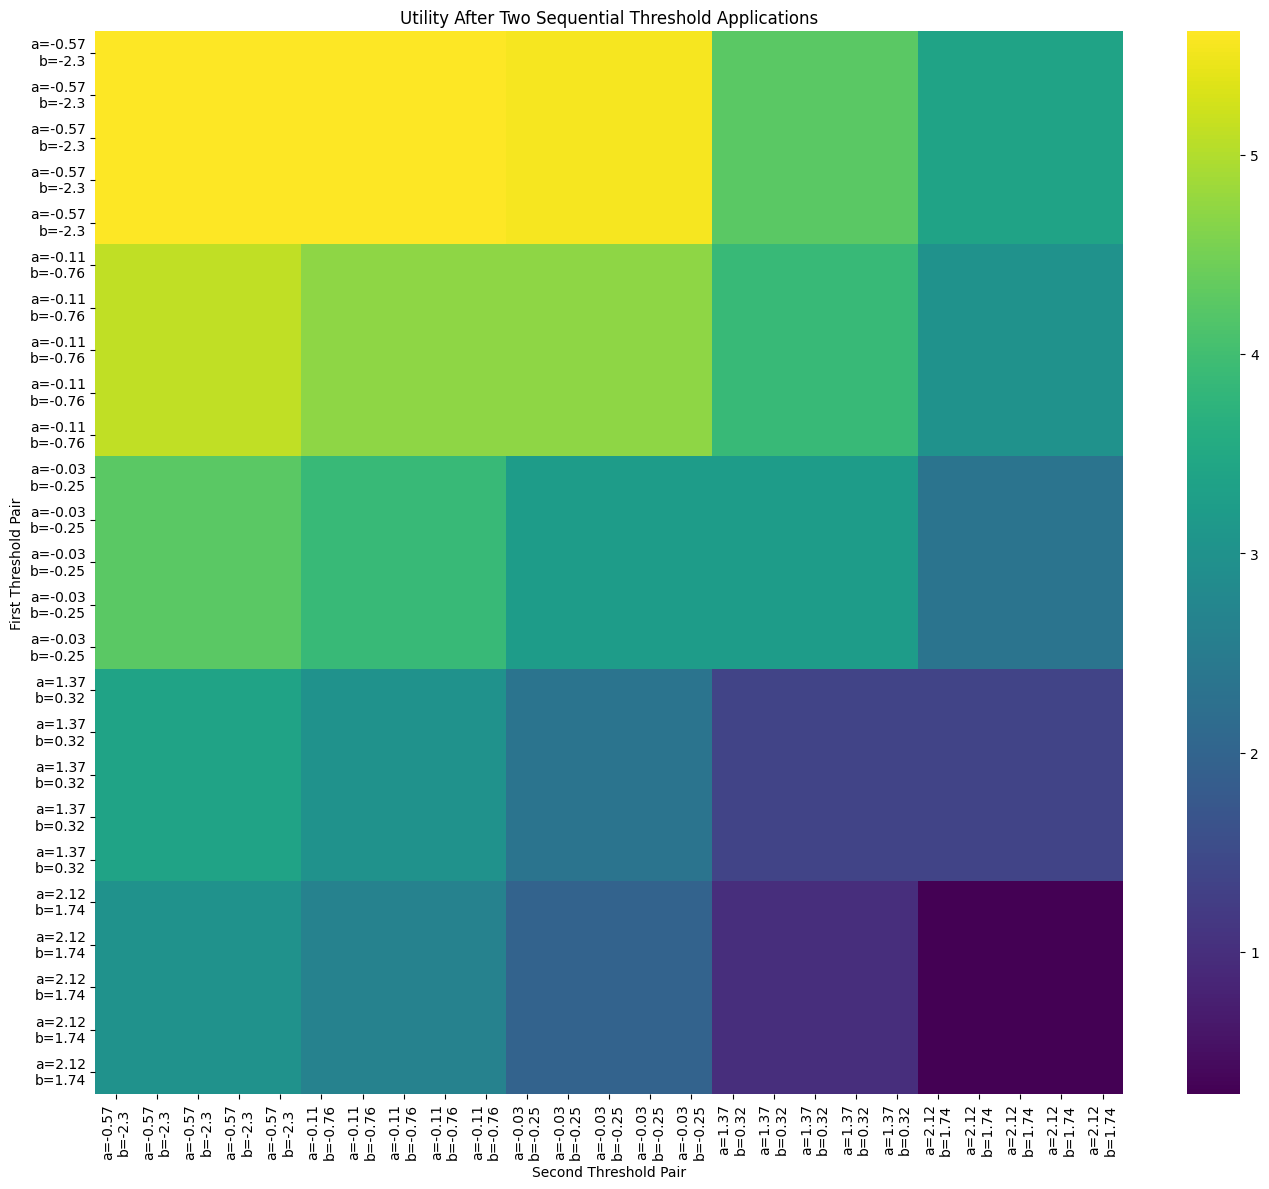

In [30]:
def utility_after_two_steps(a, b, u_plus, u_minus, c_plus, c_minus, w_a=0.5, w_b=0.5):
    a = np.asarray(a)
    b = np.asarray(b)
    N = len(a)

    delta_A = expected(a, c_plus, c_minus)
    delta_B = expected(b, c_plus, c_minus)

    A_base = np.repeat(a, N).reshape(N, N)
    B_base = np.repeat(b, N).reshape(N, N)
    delta_A_matrix = np.repeat(delta_A, N).reshape(N, N)
    delta_B_matrix = np.repeat(delta_B, N).reshape(N, N)

    # === First Step: Generate threshold pairs from A > A.T and B > B.T ===
    A_thresh_vals = A_base.flatten()
    B_thresh_vals = B_base.flatten()
    threshold_pairs = list(zip(A_thresh_vals, B_thresh_vals))  # T threshold pairs
    T = len(threshold_pairs)

    utility_matrix = np.zeros((T, T))

    for i, (a_thresh_1, b_thresh_1) in enumerate(threshold_pairs):
        # First thresholding
        A1, B1 = apply_threshold_pair(A_base, B_base, delta_A_matrix, delta_B_matrix, a_thresh_1, b_thresh_1)
        delta_A1 = expected(A1, c_plus, c_minus)
        delta_B1 = expected(B1, c_plus, c_minus)

        for j, (a_thresh_2, b_thresh_2) in enumerate(threshold_pairs):
            # Second thresholding
            A2, B2 = apply_threshold_pair(A1, B1, delta_A1, delta_B1, a_thresh_2, b_thresh_2)

            # Compute utility
            utility = w_a * expected(A2, u_plus, u_minus) + w_b * expected(B2, u_plus, u_minus)
            utility_matrix[i, j] = np.sum(utility)

    return utility_matrix, threshold_pairs
def apply_threshold_pair(A, B, delta_A, delta_B, a_thresh, b_thresh):
    A_new = np.where(A > a_thresh, A + delta_A, A)
    B_new = np.where(B > b_thresh, B + delta_B, B)
    return A_new, B_new
def plot_utility_heatmap(utility_matrix, threshold_pairs):
    import matplotlib.pyplot as plt
    import seaborn as sns

    labels = [f"a={round(a, 2)}\nb={round(b, 2)}" for a, b in threshold_pairs]

    plt.figure(figsize=(14, 12))
    sns.heatmap(utility_matrix, xticklabels=labels, yticklabels=labels, cmap='viridis')
    plt.title("Utility After Two Sequential Threshold Applications")
    plt.xlabel("Second Threshold Pair")
    plt.ylabel("First Threshold Pair")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

utility_matrix, threshold_pairs = utility_after_two_steps(
    a, b, u_plus, u_minus, c_plus, c_minus
)
plot_utility_heatmap(utility_matrix, threshold_pairs)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def test(a, b, u_plus, u_minus, c_plus, c_minus, w_a, w_b):
    a = np.asarray(a)
    b = np.asarray(b)

    delta_A = expected(a, c_plus, c_minus)
    delta_B = expected(b, c_plus, c_minus)

    N = a.shape[0]
    A_matrix = np.repeat(a, N).reshape((N, N))
    B_matrix = np.repeat(b, N).reshape((N, N))
    delta_A_matrix = np.repeat(delta_A, N).reshape((N, N))
    delta_B_matrix = np.repeat(delta_B, N).reshape((N, N))

    A_matrix = np.where(A_matrix > A_matrix.T, A_matrix + delta_A_matrix, A_matrix)
    B_matrix = np.where(B_matrix > B_matrix.T, B_matrix + delta_B_matrix, B_matrix)

    columns = [(A_matrix[:, [i]], B_matrix[:, [i]]) for i in range(N)]
    final = []
    mean_diffs = []
    utilities = []

    for col_A_vec, col_B_vec in tqdm(columns):
        n = col_A_vec.shape[0]

        col_A_vec, col_B_vec = col_A_vec.T, col_B_vec.T

        delta_col_A = expected(col_A_vec, c_plus, c_minus)
        delta_col_B = expected(col_B_vec, c_plus, c_minus)

        col_A_matrix = np.repeat(col_A_vec, n).reshape((n, n))
        col_B_matrix = np.repeat(col_B_vec, n).reshape((n, n))

        delta_col_A_matrix = np.repeat(delta_col_A, n).reshape((n, n))
        delta_col_B_matrix = np.repeat(delta_col_B, n).reshape((n, n))

        col_A_matrix = np.where(col_A_matrix > col_A_matrix.T, col_A_matrix + delta_col_A_matrix, col_A_matrix)
        col_B_matrix = np.where(col_B_matrix > col_B_matrix.T, col_B_matrix + delta_col_B_matrix, col_B_matrix)

        final.append((col_A_matrix, col_B_matrix))

        # Compute utility from one matrix (e.g., col_A_matrix)
        util = w_a * expected(col_A_vec, u_plus, u_minus) + w_b * expected(col_B_vec, u_plus, u_minus)
        util = np.sum(util)
        utilities.append(util)

        # Compute mean absolute difference between vectors
        diff = np.mean(np.abs(col_A_vec - col_B_vec))
        mean_diffs.append(diff)

    # === Plot ===
    # === Plot Heatmap ===
    import matplotlib.pyplot as plt

    heatmap_data = utilities
    print(heatmap_data.shape)

    plt.figure(figsize=(7, 6))
    im = plt.imshow(heatmap_data, cmap='viridis', origin='lower', aspect='auto')
    plt.colorbar(im, label='Utility')
    plt.title("Utility Heatmap")
    plt.xlabel("Column Index")
    plt.ylabel("Row Index")
    plt.tight_layout()
    plt.show()

    return final
test(a, b, u_plus, u_minus, c_plus, c_minus, w_a, w_b)
